In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision.utils import save_image
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from os import makedirs, listdir
from os.path import exists, join
import matplotlib.image as mpimg

%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

In [2]:
img_output_folder = './images/gan_images'
model_ckp_folder = './images/gan_ckp'

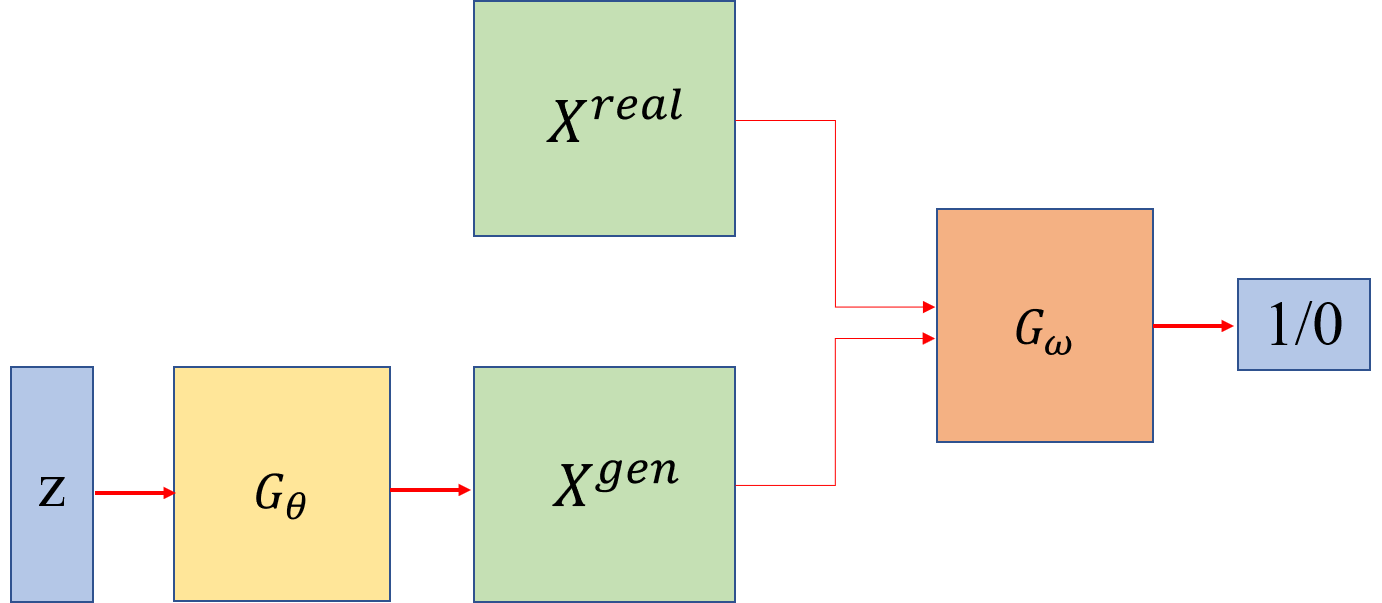

In [3]:
Image.open('./images/gan_picture.png')

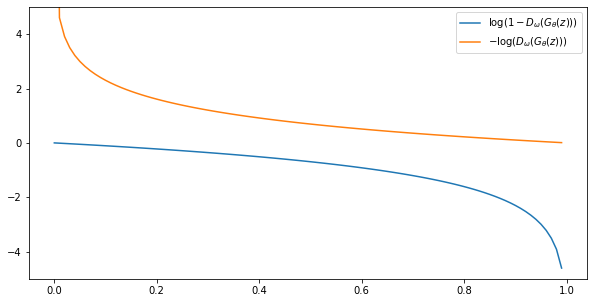

In [4]:
plt.figure(figsize=(10, 5))
xa = np.arange(1.e-10, 0.9999, 0.01)
xb = np.arange(1.e-10, 0.9999, 0.01)
plt.plot(xa, np.log(1-xa), label="$\mathrm{log}(1-D_{\omega}(G_{\\theta}(z)))$")
plt.plot(xb, -np.log(xb), label="$-\mathrm{log}(D_{\omega}(G_{\\theta}(z)))$")
plt.ylim(-5, 5)
plt.legend()
plt.show();

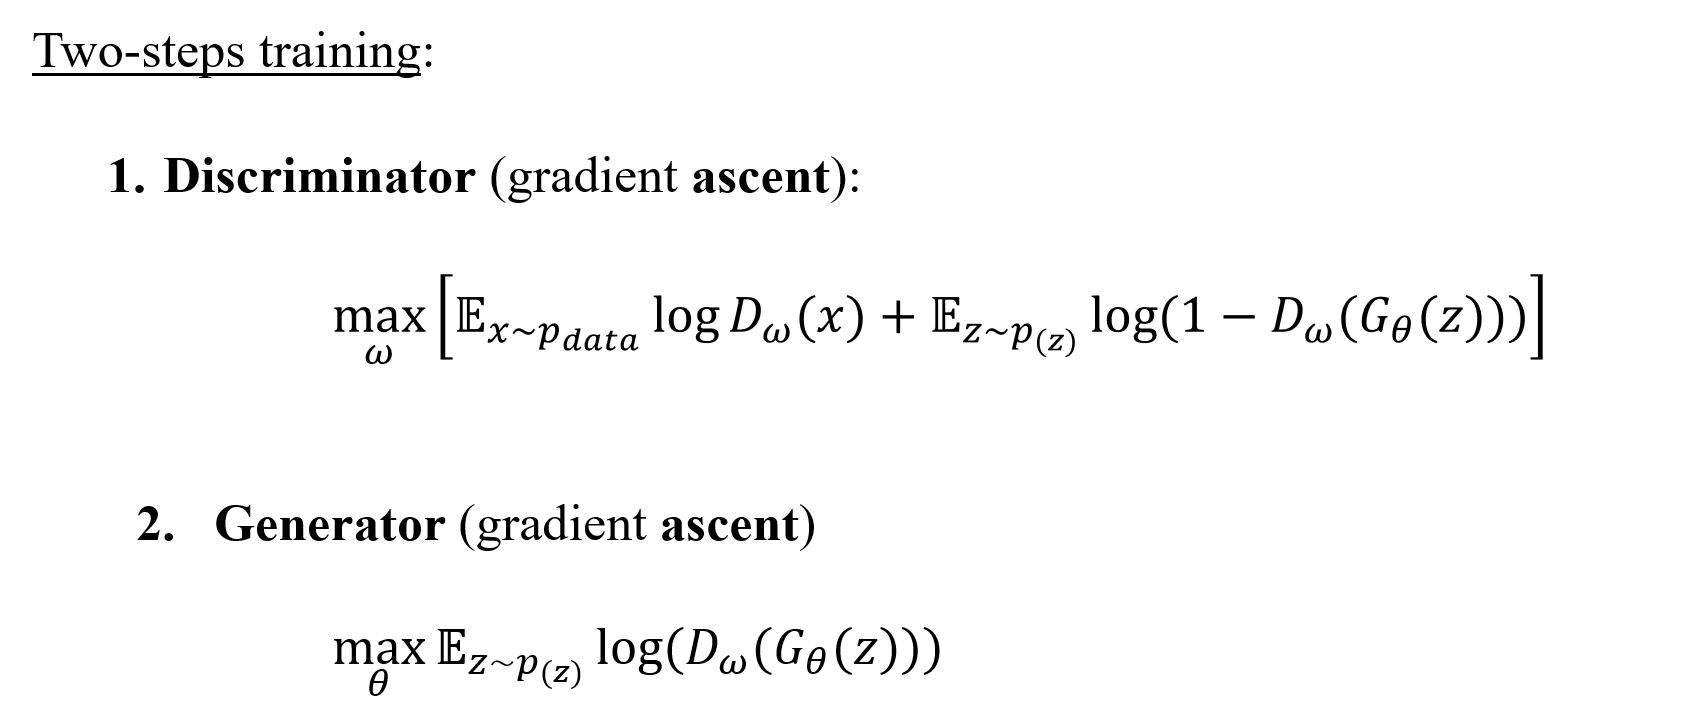

In [5]:
Image.open('./images/non_saturating_game_2.png')

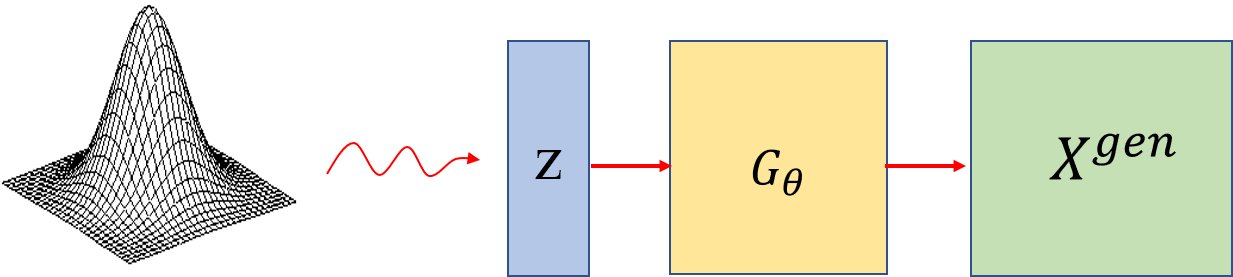

In [6]:
Image.open('./images/gan_picture_2.png')

In [ ]:
def vis_stats(model_ckp_folder, d_loss, g_loss, gen_score, r_score):
    # Visualize training stats
    gen_img_score = np.load(join(model_ckp_folder, 'gen_img_score.npy'))
    real_img_score = np.load(join(model_ckp_folder, 'real_img_score.npy'))
    epochs = gen_img_score.shape[0]

    plt.figure(figsize=(10, 5))
    plt.xlim(0, epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, epochs + 1), gen_img_score, label='gen img score')
    plt.plot(range(1, epochs + 1), real_img_score, label='real img score')    
    plt.legend()
    plt.show()


def plot_gen_imgs(arch='gan'):
    plt.figure(figsize=(20, 10))
    for i in range(0, 12, 1):
        plt.subplot(4, 3, i+1)
        plt.imshow(mpimg.imread(join(img_output_folder, f'gen_img_{arch}_{i}.png')))
        plt.xticks([])
        plt.yticks([])
    plt.show()

# GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        """The Generator model. 

        Parameters
        ----------
        latent_size : int
          Latent code size
        hidden_size : int
          Hidden layer minimum size
        image_size : int
          Image size (flatten)

        """
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
                                  nn.Linear(latent_size, hidden_size),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size, hidden_size*2),
                                  nn.BatchNorm1d(hidden_size*2, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size*2, hidden_size*4),
                                  nn.BatchNorm1d(hidden_size*4, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size*4, hidden_size*8),
                                  nn.BatchNorm1d(hidden_size*8, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size*8, image_size),
                                  nn.Tanh()
                              )

    def forward(self, z):
        img = self.generator(z)
        return img.reshape(img.shape[0], 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        """The Discriminator model. 

        Parameters
        ----------
        latent_size : int
          Latent code size
        hidden_size : int
          Hidden layer minimum size
        image_size : int
          Image size (flatten)

        """
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
                                nn.Linear(image_size, hidden_size*4),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Linear(hidden_size*4, hidden_size*2),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Linear(hidden_size*2, 1),
                                nn.Sigmoid()
                            )

    def forward(self, img):
        x = img.reshape(img.shape[0], -1)
        return self.discriminator(x).squeeze()

In [ ]:
def load_model(latent_size, hidden_size, image_size, device, load_generator=True):
    if load_generator:
        model = Generator(
                      latent_size=latent_size, 
                      hidden_size=hidden_size, 
                      image_size=image_size
                  )
    else:
        model = Discriminator(
                      latent_size=latent_size, 
                      hidden_size=hidden_size, 
                      image_size=image_size
                  )
    print(model)
    return model.to(device)

In [ ]:
latent_size = 100
hidden_size = 128
image_size = 784 # 28*28
bs_size = 128
log_freq = 200

In [ ]:
generator = load_model(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device
              )

In [ ]:
discriminator = load_model(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device,
                  load_generator=False
              )

In [ ]:
# Data loader
loader = DataLoader(
                dataset=MNIST(
                          root='./mnist_data',
                          train=True,
                          transform=Compose([
                                        ToTensor(),
                                        Normalize(mean=[0.5], std=[0.5])
                                    ]),
                          download=True
                      ),
                batch_size=bs_size, 
                shuffle=True,
                pin_memory=device=='cuda'
            )

In [ ]:
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()

In [ ]:
epochs = 10

generator.train()
discriminator.train()

d_loss = np.zeros(epochs)
g_loss = np.zeros(epochs)

real_img_score = np.zeros(epochs)
gen_img_score = np.zeros(epochs)

for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(loader):
        imgs = imgs.to(device)
        cur_bs_size = imgs.shape[0]

        # Set labels for real images and fake samples
        real_labels = torch.ones((cur_bs_size)).to(device)
        fake_labels = torch.zeros((cur_bs_size)).to(device)

        # Generate images from random noise
        z = torch.randn((cur_bs_size, latent_size)).to(device) # sample from latent space
        fake_imgs = generator(z)# generate samples

        # -- Let's begin by training the Discriminator -- #
        d_optimizer.zero_grad()

        # Forward step on real images
        d_real_out = discriminator(imgs)
        d_real_loss = criterion(d_real_out, real_labels)

        # Forward step on fake samples
        d_fake_out = discriminator(fake_imgs.detach())
        d_fake_loss = criterion(d_fake_out, fake_labels)

        discriminator_loss = (d_real_loss + d_fake_loss) * 0.5
        discriminator_loss.backward()
        d_optimizer.step()

        # -- It's now time to train the Generator -- #
        g_optimizer.zero_grad()

        z = torch.randn((cur_bs_size, latent_size)).to(device) # sample from latent space
        gen_imgs = generator(z)# generate samples
        d_output = discriminator(gen_imgs)

        generator_loss = criterion(d_output, real_labels)
        generator_loss.backward()
        g_optimizer.step()

        # -- Update Statistics -- #
        g_loss[epoch] = g_loss[epoch]*(idx/(idx+1.)) + generator_loss.item()*(1./(idx+1.))
        d_loss[epoch] = d_loss[epoch]*(idx/(idx+1.)) + discriminator_loss.item()/(idx+1.)
        real_img_score[epoch] = real_img_score[epoch]*(idx/(idx+1.)) + d_real_out.mean().item()*(1./(idx+1.))
        gen_img_score[epoch] = gen_img_score[epoch]*(idx/(idx+1.)) + d_fake_out.mean().item()*(1./(idx+1.))

        # -- Print training stats -- #
        if idx % log_freq == 0:
            print(f"[Epoch {epoch} [{idx}]/{len(loader)}]:\n\tDisciminator loss: {discriminator_loss.item()} --- Generator loss: {generator_loss.item()}")

    # Save samples to check generation learning    
    if not exists(img_output_folder):
        makedirs(img_output_folder)
    z = torch.randn((50, latent_size)).to(device) # sample from latent space 50 times
    save_image(generator(z), join(img_output_folder, f"gen_img_gan_{epoch}.png"), nrow=10, normalize=True)

    if not exists(model_ckp_folder):
        makedirs(model_ckp_folder)
    torch.save({
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict()
          },
          join(model_ckp_folder, "models_ckp.pth") 
        )
    
# -- Save teaining stats for later visualizaion -- #
np.save(join(model_ckp_folder, 'd_loss.npy'), d_loss)
np.save(join(model_ckp_folder, 'g_loss.npy'), g_loss)
np.save(join(model_ckp_folder, 'gen_img_score.npy'), gen_img_score)
np.save(join(model_ckp_folder, 'real_img_score.npy'), real_img_score)

In [ ]:
vis_stats(model_ckp_folder=model_ckp_folder, d_loss='d_loss.npy', g_loss='g_loss.npy', gen_score='gen_img_score.npy', r_score='real_img_score.npy')

In [ ]:
plot_gen_imgs()

## Sample new images

In [ ]:
# Load the Generator network
generator = load_model(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device
              )

generator.load_state_dict(torch.load(join(model_ckp_folder, "models_ckp.pth") )["generator"])
generator.eval();

In [ ]:
# Sample noise
z1 = torch.randn(size=(100, latent_size), device=device)

# Generate images
gen_samples1 = generator(z1)

save_image(gen_samples1, join(img_output_folder, "gen_img_z1.png"), nrow=10, normalize=True)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mpimg.imread(join(img_output_folder, "gen_img_z1.png")))
plt.show()

# Conditional GAN

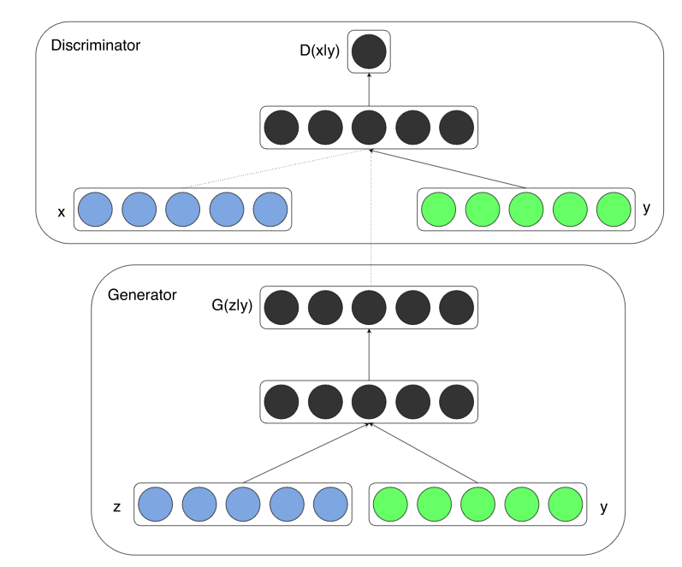

In [ ]:
class CGenerator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size, n_classes=10):
        """The Generator model. 

        Parameters
        ----------
        latent_size : int
          Latent code size
        hidden_size : int
          Hidden layer minimum size
        image_size : int
          Image size (flatten)

        """
        super(CGenerator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.generator = nn.Sequential(
                                  nn.Linear(latent_size + n_classes, hidden_size),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size, hidden_size*2),
                                  nn.BatchNorm1d(hidden_size*2, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size*2, hidden_size*4),
                                  nn.BatchNorm1d(hidden_size*4, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size*4, hidden_size*8),
                                  nn.BatchNorm1d(hidden_size*8, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  nn.Linear(hidden_size*8, image_size),
                                  nn.Tanh()
                              )

    def forward(self, z, labels):
        # Concatenate label embedding and image to produce input
        cond_z = torch.cat((self.label_emb(labels), z), -1)

        # Generate samples conditioned on the given labels
        img = self.generator(cond_z)

        return img.reshape(img.shape[0], 1, 28, 28)
    
    
class CDiscriminator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size, n_classes=10):
        """The Discriminator model. 

        Parameters
        ----------
        latent_size : int
          Latent code size
        hidden_size : int
          Hidden layer minimum size
        image_size : int
          Image size (flatten)
        n_classes : int
          Number of dataset's classes

        """
        super(CDiscriminator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.discriminator = nn.Sequential(
                                nn.Linear(image_size + n_classes, hidden_size*4),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Linear(hidden_size*4, hidden_size*2),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Linear(hidden_size*2, 1),
                                nn.Sigmoid()
                            )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        c_img = torch.cat((img.reshape(img.shape[0], -1), self.label_emb(labels)), -1)

        return self.discriminator(c_img).squeeze()

In [ ]:
def load_cmodel(latent_size, hidden_size, image_size, device, load_generator=True):
    if load_generator:
        model = CGenerator(
                      latent_size=latent_size, 
                      hidden_size=hidden_size, 
                      image_size=image_size
                  )
    else:
        model = CDiscriminator(
                      latent_size=latent_size, 
                      hidden_size=hidden_size, 
                      image_size=image_size
                  )
    print(model)
    return model.to(device)

In [ ]:
latent_size = 100
hidden_size = 128
image_size = 784
bs_size = 128
log_freq = 200

In [ ]:
generator = load_cmodel(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device
              )

In [ ]:
discriminator = load_cmodel(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device,
                  load_generator=False
              )

In [ ]:
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()

In [ ]:
epochs = 10

generator.train()
discriminator.train()

d_loss = np.zeros(epochs)
g_loss = np.zeros(epochs)

real_img_score = np.zeros(epochs)
gen_img_score = np.zeros(epochs)

for epoch in range(epochs):
    for idx, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        cur_bs_size = imgs.shape[0]

        # Set labels for real images and fake samples
        real_labels = torch.ones((cur_bs_size)).to(device)
        fake_labels = torch.zeros((cur_bs_size)).to(device)

        # Generate images from random noise
        z = torch.randn((cur_bs_size, latent_size)).to(device) # sample from latent space
        fake_imgs = generator(z, labels)# generate samples

        # -- Let's begin by training the Discriminator -- #
        d_optimizer.zero_grad()

        # Forward step on real images
        d_real_out = discriminator(imgs, labels)
        d_real_loss = criterion(d_real_out, real_labels)

        # Forward step on fake samples
        d_fake_out = discriminator(fake_imgs.detach(), labels)
        d_fake_loss = criterion(d_fake_out, fake_labels)

        discriminator_loss = (d_real_loss + d_fake_loss) * 0.5
        discriminator_loss.backward()
        d_optimizer.step()

        # -- It's now time to train the Generator -- #
        g_optimizer.zero_grad()

        z = torch.randn((cur_bs_size, latent_size)).to(device) # sample from latent space
        gen_imgs = generator(z, labels)# generate samples
        d_output = discriminator(gen_imgs, labels)

        generator_loss = criterion(d_output, real_labels)
        generator_loss.backward()
        g_optimizer.step()

        # -- Update Statistics -- #
        g_loss[epoch] = g_loss[epoch]*(idx/(idx+1.)) + generator_loss.item()*(1./(idx+1.))
        d_loss[epoch] = d_loss[epoch]*(idx/(idx+1.)) + discriminator_loss.item()/(idx+1.)
        real_img_score[epoch] = real_img_score[epoch]*(idx/(idx+1.)) + d_real_out.mean().item()*(1./(idx+1.))
        gen_img_score[epoch] = gen_img_score[epoch]*(idx/(idx+1.)) + d_fake_out.mean().item()*(1./(idx+1.))

        # -- Print training stats -- #
        if idx % log_freq == 0:
            print(f"[Epoch {epoch} [{idx}]/{len(loader)}]:\n\tDisciminator loss: {discriminator_loss.item()} --- Generator loss: {generator_loss.item()}")
  
    # Save samples to check generation learning    
    if not exists(img_output_folder):
        makedirs(img_output_folder)
    z = torch.randn((50, latent_size)).to(device) # sample from latent space 50 times
    labels_ = torch.from_numpy(np.array([num for _ in range(5) for num in range(10)])).to(device)
    save_image(generator(z, labels_), join(img_output_folder, f"gen_img_cgan_{epoch}.png"), nrow=10, normalize=True)

    if not exists(model_ckp_folder):
        makedirs(model_ckp_folder)
    torch.save({
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict()
          },
          join(model_ckp_folder, "models_cgan_ckp.pth") 
        )
    
# -- Save teaining stats for later visualizaion -- #
np.save(join(model_ckp_folder, 'cd_loss.npy'), d_loss)
np.save(join(model_ckp_folder, 'cg_loss.npy'), g_loss)
np.save(join(model_ckp_folder, 'cgen_img_score.npy'), gen_img_score)
np.save(join(model_ckp_folder, 'creal_img_score.npy'), real_img_score)

In [ ]:
plot_gen_imgs(arch='cgan')

## Sample new images

In [ ]:
# Load the CGenerator network
generator = load_cmodel(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device
              )

generator.load_state_dict(torch.load(join(model_ckp_folder, "models_cgan_ckp.pth") )["generator"])
generator.eval();

In [ ]:
# Sample noise
z = torch.randn(size=(100, latent_size), device=device)

# Get labels ranging from 0 to n_classes
labels = torch.from_numpy(np.array([num for _ in range(10) for num in range(10)])).to(device)

# Generate images
gen_samples = generator(z, labels)

save_image(gen_samples, join(img_output_folder, "gen_img_cgan.png"), nrow=10, normalize=True)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mpimg.imread(join(img_output_folder, "gen_img_cgan.png")))
plt.show()

# Deep Convolutional GAN

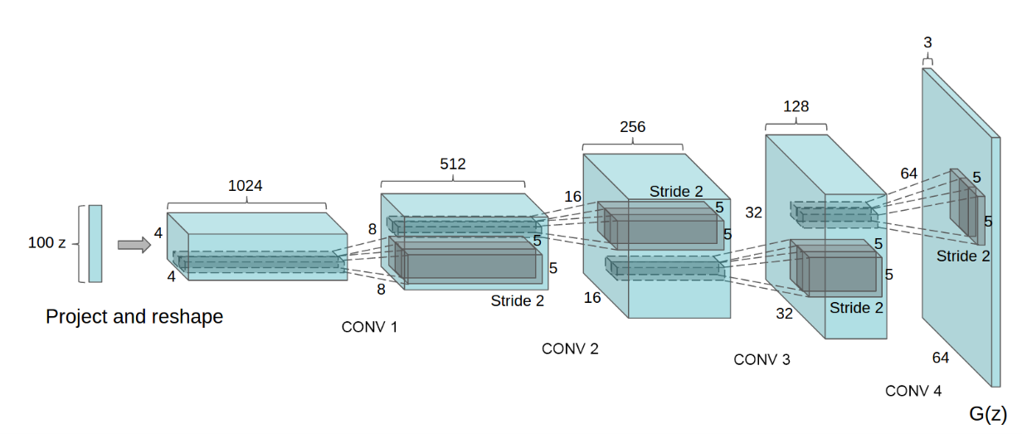

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        """The Generator model. 

        Parameters
        ----------
        latent_size : int
          Latent code size
        hidden_size : int
          Hidden layer minimum size
        image_size : int
          Image size (flatten)

        """
        super(DCGenerator, self).__init__()

        self.ds_size = image_size // 2
        self.dense = nn.Sequential(nn.Linear(latent_size, 512 * self.ds_size ** 2))

        self.conv_blocks = nn.Sequential(
                                  nn.BatchNorm2d(512),

                                  # 1st conv block
                                  nn.ConvTranspose2d(512, 256, 3),
                                  nn.BatchNorm2d(256, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  # end conv block

                                  nn.ConvTranspose2d(256, 128, 5),
                                  nn.BatchNorm2d(128, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  # 3rd conv block
                                  nn.ConvTranspose2d(128, 64, 5),
                                  nn.BatchNorm2d(64, momentum=0.8),
                                  nn.LeakyReLU(0.2, inplace=True),

                                  # 4th conv block
                                  nn.ConvTranspose2d(64, 1, 5),
                                  nn.Tanh()
                              )

    def forward(self, z):
        out = self.dense(z)
        out = out.reshape(out.shape[0], 512, self.ds_size, self.ds_size)
        return self.conv_blocks(out)


class DCDiscriminator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        """The Discriminator model. 

        Parameters
        ----------
        latent_size : int
          Latent code size
        hidden_size : int
          Hidden layer minimum size
        image_size : int
          Image size (flatten)

        """
        super(DCDiscriminator, self).__init__()

        ds_size = image_size // 2

        self.conv_blocks = nn.Sequential(
                                    # 1st conv block
                                    nn.Conv2d(1, 64, 5), 
                                    nn.LeakyReLU(0.2, inplace=True), 
                                    nn.Dropout2d(0.25),
                                    # 2nd conv block
                                    nn.Conv2d(64, 128, 5), 
                                    nn.LeakyReLU(0.2, inplace=True), 
                                    nn.Dropout2d(0.25),
                                    nn.BatchNorm2d(128, momentum=0.8),
                                    # 3rd conv block
                                    nn.Conv2d(128, 256, 5), 
                                    nn.LeakyReLU(0.2, inplace=True), 
                                    nn.Dropout2d(0.25),
                                    nn.BatchNorm2d(256, momentum=0.8),
                                    # 4th conv block
                                    nn.Conv2d(256, 512, 3), 
                                    nn.LeakyReLU(0.2, inplace=True), 
                                    nn.Dropout2d(0.25)
                                )

        self.dense = nn.Sequential(nn.Linear(512 * ds_size ** 2, 1), nn.Sigmoid())
    
    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        return self.dense(out).squeeze()

In [ ]:
def load_dcmodel(latent_size, hidden_size, image_size, device, load_generator=True):
    if load_generator:
        model = DCGenerator(
                      latent_size=latent_size, 
                      hidden_size=hidden_size, 
                      image_size=image_size
                  )
    else:
        model = DCDiscriminator(
                      latent_size=latent_size, 
                      hidden_size=hidden_size, 
                      image_size=image_size
                  )
    print(model)
    return model.to(device)

In [ ]:
latent_size = 100
hidden_size = 128
image_size = 28 # 28*28
bs_size = 128
log_freq = 200

In [ ]:
generator = load_dcmodel(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device
              )

In [ ]:
discriminator = load_dcmodel(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device,
                  load_generator=False
              )

In [ ]:
g_optimizer = Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [ ]:
criterion = nn.BCELoss()

In [ ]:
epochs = 10

generator.train()
discriminator.train()

d_loss = np.zeros(epochs)
g_loss = np.zeros(epochs)

real_img_score = np.zeros(epochs)
gen_img_score = np.zeros(epochs)

for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(loader):
        imgs = imgs.to(device)
        cur_bs_size = imgs.shape[0]

        # Set labels for real images and fake samples
        real_labels = torch.ones((cur_bs_size)).to(device)
        fake_labels = torch.zeros((cur_bs_size)).to(device)

        # Generate images from random noise
        z = torch.randn((cur_bs_size, latent_size)).to(device) # sample from latent space
        fake_imgs = generator(z)# generate samples

        # -- Let's begin by training the Discriminator -- #
        d_optimizer.zero_grad()

        # Forward step on real images
        d_real_out = discriminator(imgs)
        d_real_loss = criterion(d_real_out, real_labels)

        # Forward step on fake samples
        d_fake_out = discriminator(fake_imgs.detach())
        d_fake_loss = criterion(d_fake_out, fake_labels)

        discriminator_loss = (d_real_loss + d_fake_loss) * 0.5
        discriminator_loss.backward()
        d_optimizer.step()

        # -- It's now time to train the Generator -- #
        g_optimizer.zero_grad()

        z = torch.randn((cur_bs_size, latent_size)).to(device) # sample from latent space
        gen_imgs = generator(z)# generate samples
        d_output = discriminator(gen_imgs)

        generator_loss = criterion(d_output, real_labels)
        generator_loss.backward()
        g_optimizer.step()

        # -- Update Statistics -- #
        g_loss[epoch] = g_loss[epoch]*(idx/(idx+1.)) + generator_loss.item()*(1./(idx+1.))
        d_loss[epoch] = d_loss[epoch]*(idx/(idx+1.)) + discriminator_loss.item()/(idx+1.)
        real_img_score[epoch] = real_img_score[epoch]*(idx/(idx+1.)) + d_real_out.mean().item()*(1./(idx+1.))
        gen_img_score[epoch] = gen_img_score[epoch]*(idx/(idx+1.)) + d_fake_out.mean().item()*(1./(idx+1.))

        # -- Print training stats -- #
        if idx % log_freq == 0:
            print(f"[Epoch {epoch} [{idx}]/{len(loader)}]:\n\tDisciminator loss: {discriminator_loss.item()} --- Generator loss: {generator_loss.item()}")
  
    # Save samples to check generation learning    
    if not exists(img_output_folder):
        makedirs(img_output_folder)
    z = torch.randn((50, latent_size)).to(device) # sample from latent space 50 times
    save_image(generator(z), join(img_output_folder, f"gen_img_dcgan_{epoch}.png"), nrow=10, normalize=True)

    if not exists(model_ckp_folder):
        makedirs(model_ckp_folder)
    torch.save({
            "generator": generator.state_dict(),
            "discriminator": discriminator.state_dict()
          },
          join(model_ckp_folder, "models_dcgan_ckp.pth") 
        )
    
# -- Save teaining stats for later visualizaion -- #
np.save(join(model_ckp_folder, 'dcd_loss.npy'), d_loss)
np.save(join(model_ckp_folder, 'dcg_loss.npy'), g_loss)
np.save(join(model_ckp_folder, 'dcgen_img_score.npy'), gen_img_score)
np.save(join(model_ckp_folder, 'dcreal_img_score.npy'), real_img_score)

In [ ]:
vis_stats(model_ckp_folder=model_ckp_folder, d_loss='dcd_loss.npy', g_loss='dcg_loss.npy', gen_score='dcgen_img_score.npy', r_score='dcreal_img_score.npy')

In [ ]:
plot_gen_imgs(arch='dcgan')

## Sample new images

In [ ]:
# Load the DCGenerator network
generator = load_dcmodel(
                  latent_size=latent_size, 
                  hidden_size=hidden_size, 
                  image_size=image_size,
                  device=device
              )

generator.load_state_dict(torch.load(join(model_ckp_folder, "models_dcgan_ckp.pth") )["generator"])
generator.eval();

In [ ]:
# Sample noise
z = torch.randn(size=(100, latent_size), device=device)

# Generate images
gen_samples = generator(z)

save_image(gen_samples, join(img_output_folder, "gen_img_dcgan.png"), nrow=10, normalize=True)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mpimg.imread(join(img_output_folder, "gen_img_dcgan.png")))
plt.show()